<a href="https://colab.research.google.com/github/TharinsaMudalige/Neuron-Brain_Tumor_Detection_Classification_with_XAI/blob/Detection-Classification-VIT/Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Class Names: ['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma', 'meningioma', 'no tumour', 'pituitary']
Epoch 1/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 369s 513ms/step - accuracy: 0.1064 - loss: 2.7372 - val_accuracy: 0.1802 - val_loss: 2.4773
Epoch 2/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 357s 509ms/step - accuracy: 0.2151 - loss: 2.3792 - val_accuracy: 0.3460 - val_loss: 1.9805
Epoch 3/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 352s 502ms/step - accuracy: 0.3806 - loss: 1.8989 - val_accuracy: 0.4758 - val_loss: 1.6326
Epoch 4/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 356s 508ms/step - accuracy: 0.5054 - loss: 1.5117 - val_accuracy: 0.5721 - val_loss: 1.3159
Epoch 5/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 355s 507ms/step - accuracy: 0.6142 - loss: 1.1830 - val_accuracy: 0.6746 - val_loss: 1.0200
Epoch 6/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 359s 512ms/step - accuracy: 0.6767 - loss: 0.9910 

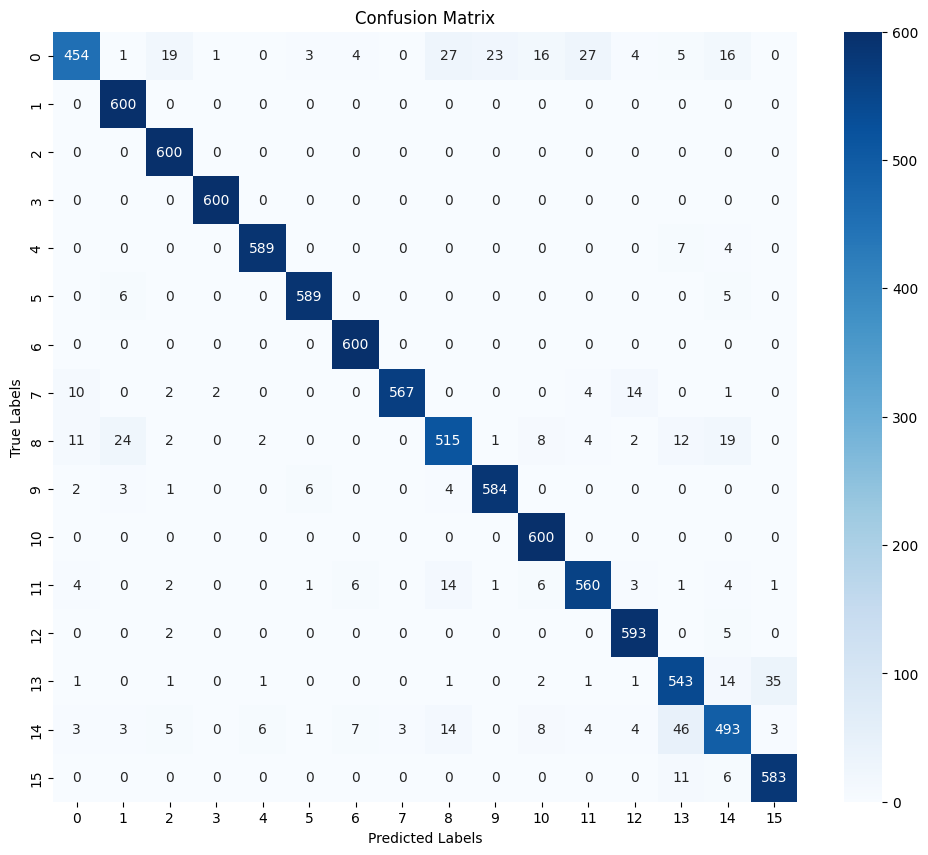

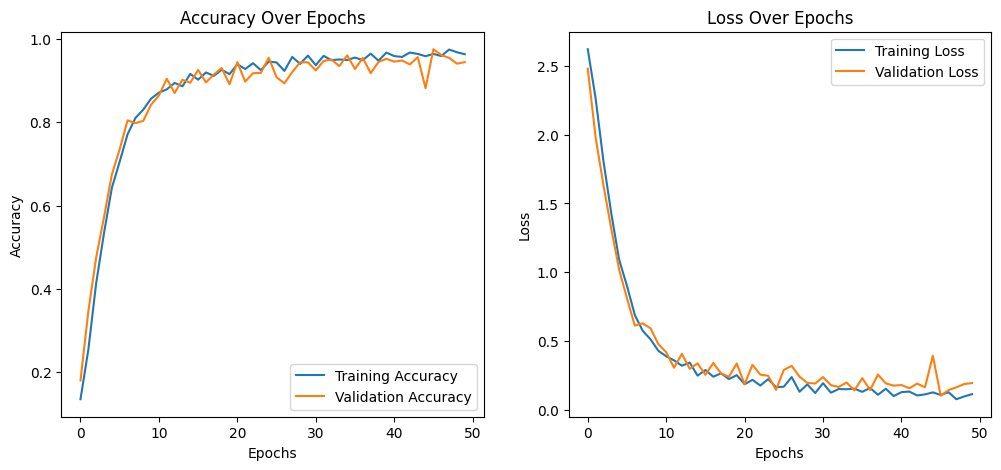

In [ ]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image  # For image processing
from tensorflow.keras import layers, models  # For building the model
from sklearn.model_selection import train_test_split  # For splitting the dataset
from sklearn.metrics import classification_report, confusion_matrix  # For evaluation metrics
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For visualizing the confusion matrix

# Define dataset directory
base_dir = "/content/drive/MyDrive/Colab Notebooks/Preprocessed_Dataset_classes_morepreprocess_techniques"

def load_dataset(base_dir):
    """Load the entire dataset into memory."""
    images = []  # List to store image data
    labels = []  # List to store corresponding labels
    # Get class names by listing directories (excluding hidden ones)
    class_names = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d)) and not d.startswith('.')])
    print(f"Class Names: {class_names}")  # Print class names for reference

    for label, class_name in enumerate(class_names):  # Loop through each class
        class_dir = os.path.join(base_dir, class_name)  # Path to the class directory
        for file in os.listdir(class_dir):  # Loop through each file in the class directory
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):  # Check for valid image files
                file_path = os.path.join(class_dir, file)  # Full path to the image file
                try:
                    # Load image, convert to grayscale, and resize to 224x224
                    image = tf.keras.preprocessing.image.load_img(file_path, color_mode='grayscale', target_size=(224, 224))
                    # Convert image to numpy array and normalize pixel values to [0, 1]
                    image = tf.keras.preprocessing.image.img_to_array(image) / 255.0
                    images.append(image)  # Append processed image to the list
                    labels.append(label)  # Append corresponding label
                except Exception as e:
                    print(f"[ERROR] Failed to process {file_path}: {e}")  # Log errors if any

    # Convert lists to numpy arrays for compatibility with TensorFlow
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)

# Load the dataset
images, labels = load_dataset(base_dir)

# Split data into training (70%) and testing (30%) sets with stratified sampling
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42, stratify=labels
)

def create_vit_model(input_shape, num_classes):
    """Build a Vision Transformer (ViT) model."""
    inputs = layers.Input(shape=input_shape)  # Define input layer with the given shape

    # Patch embedding: Split image into patches and apply a convolution
    patch_size = 16  # Size of each patch
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)  # Calculate number of patches
    patches = layers.Conv2D(64, patch_size, patch_size)(inputs)  # Apply convolution to create patches
    patches = layers.Reshape((num_patches, -1))(patches)  # Reshape to (num_patches, embedding_dim)

    # Positional embedding: Learnable embeddings for patch positions
    positional_embedding = layers.Embedding(input_dim=num_patches, output_dim=64)(tf.range(num_patches))
    x = patches + positional_embedding  # Add positional embedding to patches

    # Transformer blocks
    for _ in range(4):  # Apply 4 transformer layers
        # Multi-head self-attention
        attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
        x = layers.Add()([x, attention_output])  # Add residual connection
        x = layers.LayerNormalization()(x)  # Apply layer normalization

        # Feed-forward network
        ff_output = layers.Dense(128, activation='relu')(x)  # Fully connected layer with ReLU
        ff_output = layers.Dense(64)(ff_output)  # Another fully connected layer
        x = layers.Add()([x, ff_output])  # Add residual connection
        x = layers.LayerNormalization()(x)  # Apply layer normalization

    # Classification head: Pool the features and apply softmax for class probabilities
    x = layers.GlobalAveragePooling1D()(x)  # Global average pooling
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Output layer with softmax activation

    return models.Model(inputs, outputs)  # Return the model

# Create the ViT model
input_shape = (224, 224, 1)  # Input shape for grayscale images (224x224x1)
num_classes = len(np.unique(labels))  # Number of classes (unique labels)
model = create_vit_model(input_shape, num_classes)  # Build the model

# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model for 20 epochs with a batch size of 32
history = model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=50, batch_size=32)

# Evaluate the model on the test set
predictions = model.predict(test_images)  # Get predictions for test images
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class labels

# Classification report to evaluate precision, recall, and F1-score
print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

# Confusion matrix to analyze prediction errors
cm = confusion_matrix(test_labels, predicted_labels)  # Compute confusion matrix
plt.figure(figsize=(12, 10))  # Set figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted Labels')  # Label x-axis
plt.ylabel('True Labels')  # Label y-axis
plt.title('Confusion Matrix')  # Title of the plot
plt.show()  # Display the plot

# Plot training and validation metrics
def plot_metrics(history):
    """Plot training and validation accuracy and loss over epochs."""
    plt.figure(figsize=(12, 5))  # Set figure size

    # Plot accuracy
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        plt.subplot(1, 2, 1)  # Create subplot for accuracy
        plt.plot(history.history['accuracy'], label='Training Accuracy')  # Plot training accuracy
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
        plt.title('Accuracy Over Epochs')  # Title of the plot
        plt.xlabel('Epochs')  # Label x-axis
        plt.ylabel('Accuracy')  # Label y-axis
        plt.legend()  # Add legend

    # Plot loss
    plt.subplot(1, 2, 2)  # Create subplot for loss
    plt.plot(history.history['loss'], label='Training Loss')  # Plot training loss
    plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot validation loss
    plt.title('Loss Over Epochs')  # Title of the plot
    plt.xlabel('Epochs')  # Label x-axis
    plt.ylabel('Loss')  # Label y-axis
    plt.legend()  # Add legend

    plt.show()  # Display the plots

# Call to plot the metrics
plot_metrics(history)


Class Names: ['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma', 'meningioma', 'no tumour', 'pituitary']
Epoch 1/50
1401/1401 ━━━━━━━━━━━━━━━━━━━━ 443s 309ms/step - accuracy: 0.1271 - loss: 2.6505 - val_accuracy: 0.2553 - val_loss: 2.1838
Epoch 2/50
1401/1401 ━━━━━━━━━━━━━━━━━━━━ 455s 325ms/step - accuracy: 0.2899 - loss: 2.1507 - val_accuracy: 0.3946 - val_loss: 1.8282
Epoch 3/50
1401/1401 ━━━━━━━━━━━━━━━━━━━━ 462s 330ms/step - accuracy: 0.4616 - loss: 1.6610 - val_accuracy: 0.5491 - val_loss: 1.4026
Epoch 4/50
1401/1401 ━━━━━━━━━━━━━━━━━━━━ 449s 320ms/step - accuracy: 0.5534 - loss: 1.3893 - val_accuracy: 0.5774 - val_loss: 1.3026
Epoch 5/50
1401/1401 ━━━━━━━━━━━━━━━━━━━━ 424s 302ms/step - accuracy: 0.5863 - loss: 1.2744 - val_accuracy: 0.5253 - val_loss: 1.4171
Epoch 6/50
1401/1401 ━━━━━━━━━━━━━━━━━━━━ 418s 299ms/step - accuracy: 0.6094 - l

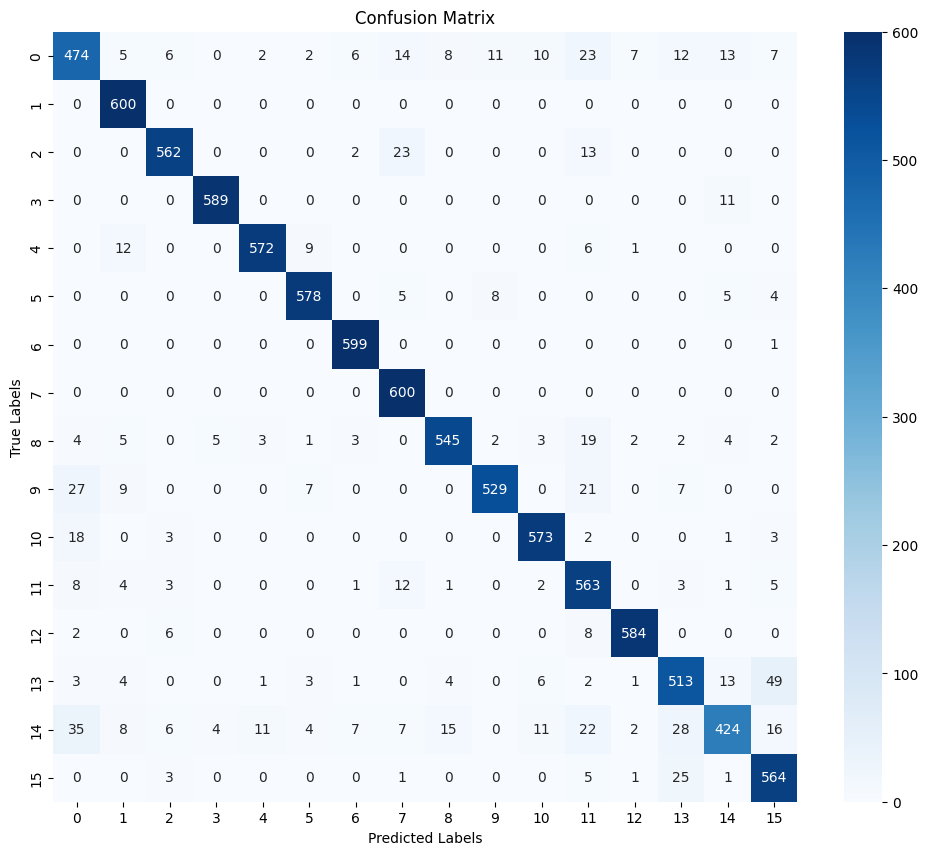

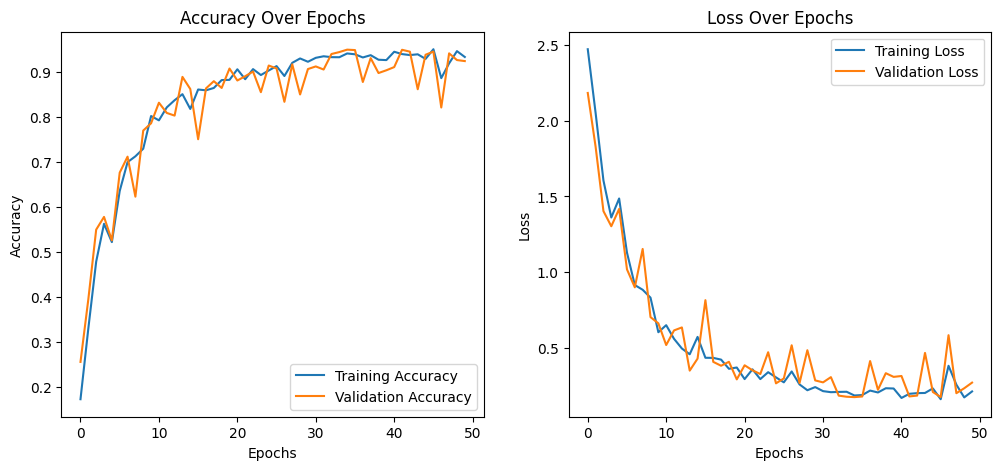

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define dataset directory
base_dir = "/content/drive/MyDrive/Colab Notebooks/Preprocessed_Dataset_classes_morepreprocess_techniques"

def load_dataset(base_dir):
    """Load the entire dataset into memory."""
    images = []  # List to store image data
    labels = []  # List to store corresponding labels
    class_names = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d)) and not d.startswith('.')])
    print(f"Class Names: {class_names}")

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(base_dir, class_name)
        for file in os.listdir(class_dir):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(class_dir, file)
                try:
                    # Load and preprocess image
                    image = tf.keras.preprocessing.image.load_img(file_path, color_mode='grayscale', target_size=(224, 224))
                    image = tf.keras.preprocessing.image.img_to_array(image) / 255.0
                    images.append(image)
                    labels.append(label)
                except Exception as e:
                    print(f"[ERROR] Failed to process {file_path}: {e}")

    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)

# Load the dataset
images, labels = load_dataset(base_dir)

# Split data into training (70%) and testing (30%) sets with stratified sampling
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42, stratify=labels
)

def create_vit_model(input_shape, num_classes):
    """Build a Vision Transformer (ViT) model."""
    inputs = layers.Input(shape=input_shape)

    # Flatten the image into patches
    patch_size = 16
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    patch_dim = patch_size * patch_size * input_shape[2]  # Flattened patch size
    patches = layers.Reshape((num_patches, patch_dim))(inputs)

    # Linear projection of patches
    x = layers.Dense(64)(patches)

    # Positional embedding
    positional_embedding = layers.Embedding(input_dim=num_patches, output_dim=64)(tf.range(num_patches))
    x = x + positional_embedding

    # Transformer blocks
    for _ in range(4):
        # Multi-head self-attention
        attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
        x = layers.Add()([x, attention_output])
        x = layers.LayerNormalization()(x)

        # Feed-forward network
        ff_output = layers.Dense(128, activation='relu')(x)
        ff_output = layers.Dense(64)(ff_output)
        x = layers.Add()([x, ff_output])
        x = layers.LayerNormalization()(x)

    # Classification head
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

# Create the ViT model
input_shape = (224, 224, 1)
num_classes = len(np.unique(labels))
model = create_vit_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=50, batch_size=16)

# Evaluate the model
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

# Confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Plot training metrics
def plot_metrics(history):
    """Plot training and validation accuracy and loss."""
    plt.figure(figsize=(12, 5))

    # Accuracy
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot metrics
plot_metrics(history)


Import Libraries

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


Load the Dataset

In [ ]:
# Define dataset directory
base_dir = "/content/drive/MyDrive/Colab Notebooks/Preprocessed_Dataset_classes_morepreprocess_techniques"

In [ ]:
def load_dataset(base_dir):
    """Load the entire dataset into memory."""
    images = []  # List to store image data
    labels = []  # List to store corresponding labels
    class_names = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d)) and not d.startswith('.')])
    print(f"Class Names: {class_names}")

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(base_dir, class_name)
        for file in os.listdir(class_dir):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(class_dir, file)
                try:
                    # Load and preprocess image
                    image = tf.io.read_file(file_path)
                    image = tf.image.decode_image(image, channels=1)  # Decode as grayscale
                    image = tf.image.resize(image, [224, 224]) / 255.0  # Resize and normalize
                    images.append(image)
                    labels.append(label)
                except Exception as e:
                    print(f"[ERROR] Failed to process {file_path}: {e}")

    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)

In [ ]:
# Load the dataset
images, labels = load_dataset(base_dir)

Class Names: ['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma', 'meningioma', 'no tumour', 'pituitary']


Split the dataset

In [ ]:
# Split data into training (70%) and testing (30%) sets with stratified sampling
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42, stratify=labels
)

ViT model architecture

In [ ]:
# Patches layer: This layer extracts patches from the input image to be processed by the Vision Transformer (ViT)
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size  # Define patch size (e.g., 16x16 pixels)

    def call(self, images):
        # Extract patches from the image
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],  # Size of patches
            strides=[1, self.patch_size, self.patch_size, 1],  # How the patches move over the image
            rates=[1, 1, 1, 1],  # Stride rate (fixed to 1 for this case)
            padding="VALID",  # Padding strategy
        )
        batch_size = tf.shape(images)[0]  # Get the batch size
        num_patches = (images.shape[1] // self.patch_size) * (images.shape[2] // self.patch_size)  # Number of patches
        patch_dims = patches.shape[-1]  # Dimensions of each patch
        return tf.reshape(patches, [batch_size, num_patches, patch_dims])  # Reshape to the desired format

# Self-attention mechanism: The attention mechanism helps the model focus on relevant parts of the image
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim  # Embedding dimension (size of input vectors)
        self.num_heads = num_heads  # Number of attention heads
        self.projection_dim = embed_dim // num_heads  # Projection dimension per attention head

        # Dense layers for query, key, and value projections
        self.query_dense = tf.keras.layers.Dense(embed_dim)
        self.key_dense = tf.keras.layers.Dense(embed_dim)
        self.value_dense = tf.keras.layers.Dense(embed_dim)
        self.combine_heads = tf.keras.layers.Dense(embed_dim)  # Combine heads after attention computation

    def split_heads(self, inputs, batch_size):
        # Split inputs into multiple attention heads
        inputs = tf.reshape(inputs, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])  # Transpose to [batch_size, num_heads, seq_len, projection_dim]

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]  # Get the batch size
        # Apply dense layers to create queries, keys, and values
        query = self.split_heads(self.query_dense(inputs), batch_size)
        key = self.split_heads(self.key_dense(inputs), batch_size)
        value = self.split_heads(self.value_dense(inputs), batch_size)

        # Calculate the attention scores
        score = tf.matmul(query, key, transpose_b=True) / tf.math.sqrt(float(self.projection_dim))
        weights = tf.nn.softmax(score, axis=-1)  # Softmax to get attention weights
        attention = tf.matmul(weights, value)  # Apply the attention weights to the values

        # Reshape the attention output and combine heads
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        return self.combine_heads(concat_attention)  # Combine the heads and return the output

# Transformer block: This block applies self-attention and a feed-forward neural network
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_dim, num_heads)  # Self-attention mechanism
        self.ffn = tf.keras.Sequential([  # Feed-forward neural network (FFN)
            tf.keras.layers.Dense(ff_dim, activation='relu'),  # First layer of the FFN
            tf.keras.layers.Dense(embed_dim)  # Second layer of the FFN
        ])
        # Layer normalization and dropout for stabilizing training
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        # Apply self-attention mechanism
        attn_output = self.attention(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        # Add and normalize the attention output
        out1 = self.layernorm1(inputs + attn_output)
        # Apply the feed-forward neural network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        # Add and normalize the final output
        return self.layernorm2(out1 + ffn_output)

# Patch encoder: This encodes the image patches into embeddings
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, embed_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches  # Number of patches in the image
        self.projection = tf.keras.layers.Dense(embed_dim)  # Dense layer to project patches to embedding space
        self.position_embedding = tf.keras.layers.Embedding(input_dim=num_patches, output_dim=embed_dim)  # Position embeddings

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)  # Generate position indices
        return self.projection(patches) + self.position_embedding(positions)  # Add positional encoding to patch embeddings

# Create the Vision Transformer model: This function puts everything together to form the final model
def create_vit_model(input_shape, num_classes=2, patch_size=16, embed_dim=256, num_heads=8, ff_dim=512, num_layers=4, dropout_rate=0.5, l2_reg=0.01):
    inputs = tf.keras.layers.Input(shape=input_shape)  # Input layer
    patches = Patches(patch_size)(inputs)  # Extract patches from the image
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)  # Number of patches
    encoded_patches = PatchEncoder(num_patches, embed_dim)(patches)  # Encode patches with positional encoding

    # Apply Transformer blocks with dropout and L2 regularization
    for _ in range(num_layers):
        encoded_patches = TransformerBlock(embed_dim, num_heads, ff_dim, rate=dropout_rate)(encoded_patches)

    # Global average pooling and final classification layers
    x = tf.keras.layers.GlobalAveragePooling1D()(encoded_patches)  # Pool over sequence of patches
    x = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)  # Dense with L2
    x = tf.keras.layers.Dropout(dropout_rate)(x)  # Dropout for regularization
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)  # Final output layer for classification

    return tf.keras.Model(inputs, outputs)  # Return the complete model


In [ ]:
# Create the ViT model
input_shape = (224, 224, 1)
num_classes = len(np.unique(labels))
model = create_vit_model(input_shape, num_classes)


Compile the model

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=10, batch_size=32)

Epoch 1/10
701/701 ━━━━━━━━━━━━━━━━━━━━ 707s 1s/step - accuracy: 0.0603 - loss: 2.7730 - val_accuracy: 0.0625 - val_loss: 2.7726
Epoch 2/10
173/701 ━━━━━━━━━━━━━━━━━━━━ 7:29 851ms/step - accuracy: 0.0597 - loss: 2.7727

KeyboardInterrupt: 

Evaluate the model

In [ ]:
# Evaluate the model
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

In [ ]:
# Classification report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

In [ ]:
# Confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Plot training metrics
def plot_metrics(history):
    """Plot training and validation accuracy and loss."""
    plt.figure(figsize=(12, 5))

    # Accuracy
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot metrics
plot_metrics(history)
